In [1]:
pip freeze

absl-py==0.12.0
alabaster==0.7.12
anaconda-client==1.7.2
anaconda-navigator==1.10.0
anaconda-project==0.8.3
argh==0.26.2
argon2-cffi @ file:///C:/ci/argon2-cffi_1596828585465/work
asn1crypto @ file:///tmp/build/80754af9/asn1crypto_1596577642040/work
astroid @ file:///C:/ci/astroid_1592487315634/work
astropy==4.0.2
astunparse==1.6.3
async-generator==1.10
atomicwrites==1.4.0
attrs @ file:///tmp/build/80754af9/attrs_1604765588209/work
autopep8 @ file:///tmp/build/80754af9/autopep8_1596578164842/work
Babel @ file:///tmp/build/80754af9/babel_1605108370292/work
backcall==0.2.0
backports.functools-lru-cache==1.6.1
backports.shutil-get-terminal-size==1.0.0
backports.tempfile==1.0
backports.weakref==1.0.post1
bcrypt @ file:///C:/ci/bcrypt_1597936263757/work
beautifulsoup4 @ file:///tmp/build/80754af9/beautifulsoup4_1601924105527/work
bitarray @ file:///C:/ci/bitarray_1605065210072/work
bkcharts==0.2
bleach @ file:///tmp/build/80754af9/bleach_1600439572647/work
bokeh @ file:///C:/ci/bokeh_160329

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import layers
import spektral
import os
import scipy.sparse as sp
import pandas as pd

np.random.seed(1)
import sys
nums = np.arange(2000)
np.set_printoptions(threshold=sys.maxsize)


In [13]:
# Basic System Parameters

# number of periods 24-Hour day ahead case
nPrd    = 24 

# IEEE 24-Bus System 
# Modified to have one generator per node: 
# 1. Similar generators in a node clubbed as one larger generator
# 2. If two or more types of generator in a node then move each type a geographically close node
nBus    = 24
nGen    = 15
nBranch = 38
SysName = "24Bus"

# # IEEE 73-Bus System (Modified to have one generator per node)
# nBus    = 73
# nGen    = 45
# nBranch = 117
# SysName = "73Bus"

# # IEEE 118-Bus System
# nBus    = 118 
# nGen    = 54 
# nBranch = 186 
# SysName = "118Bus"

# # NorthCarolina 500-Bus System
# nBus    = 500
# nGen    = 90
# nBranch = 597
# SysName = "500Bus"

# Forming data directory name
DataDir = "Data/IEEE" + SysName +"/"
OptimizationFolder = "DataCollectionOptimization(BaseSCUC)/"

In [14]:
#Read Topology info
Bra_dataFile = DataDir + OptimizationFolder + "dataFileTxInfo" + SysName +".dat"
Bra_data = pd.read_csv(Bra_dataFile)
print (Bra_data.info)
fBus = Bra_data["branch_fbus"]
tBus = Bra_data["branch_tbus"]
kRating = Bra_data["branch_rateA"]
kBranch_b = Bra_data["branch_b"]

#Read gen info
Gen_dataFile = DataDir + OptimizationFolder + "GenData_1GPerBus.dat"
Gen_data = pd.read_csv(Gen_dataFile)
print (Gen_data.info)
gBus = Gen_data["genD_bus"]


<bound method DataFrame.info of     branchNo  branch_fbus  branch_tbus  branch_b  branch_rateA  branch_rateC
0          1            1            2  -71.4286         157.5        180.00
1          2            1            3   -4.7393         157.5        198.00
2          3            1            5  -11.7647         157.5        198.00
3          4            2            4   -7.8740         157.5        198.00
4          5            2            6   -5.2083         157.5        198.00
5          6            3            9   -8.4034         157.5        198.00
6          7            3           24  -11.9048         360.0        540.00
7          8            4            9   -9.6154         157.5        198.00
8          9            5           10  -11.3636         157.5        198.00
9         10            6           10  -16.3934         157.5        180.00
10        11            7            8  -16.3934         157.5        198.00
11        12            8            9   -6.

In [17]:
# data set 24 Bus (Each samples is a run for 24-Hour based from optimization)
Demand_fileName = DataDir + OptimizationFolder + "demand" + SysName + ".txt"
dfNDmd =  loadtxt(Demand_fileName, delimiter=',') # Nodal demand NBus*24-Hours sequences

# (Gen features Maybe not reqd)
Commitment_fileName = DataDir + OptimizationFolder + "commitment" + SysName + ".txt"
dfGCmt = loadtxt(Commitment_fileName, delimiter=',') # Generator Commitment Information NGen*24-Hours sequences

# lets start with line loading # Line flows NBranch*24 Hour sequences
Flow_fileName = DataDir + OptimizationFolder + "flows" + SysName + ".txt"
dfLFlw = loadtxt(Flow_fileName, delimiter=',') 

# each graph(sample) must have 24 Nodal values and edge connection(constant, topology does not chage)
x_data = dfNDmd
nSamples = len(x_data)
y_dataCmt = dfGCmt
y_dataFlow = abs(dfLFlw) # use absolute flow

# Shuffle (x, y) in unison
indices = np.arange(len(y_dataCmt))
np.random.shuffle(indices)
x_data = x_data[indices]
y_dataCmt = y_dataCmt[indices]
y_dataFlow = y_dataFlow[indices]

# normalize demand by MBase = 100 MW
x_data = x_data/100

Data/IEEE24Bus/DataCollectionOptimization(BaseSCUC)/commitment24Bus.txt


In [18]:
print (indices)

[1462  510  612 1322  993  190 1716 1048 1407  881  900 1427  158 1201
  679  120 1707 1627  275 1213  382   48  537   47 1274  108  507  804
 1410 1059  258 1105  281 1473  428  957 1313  111 1012 1383  791  330
 1573  231 1051  772 1481 1215  852 1575  593 1435 1701  478 1670 1588
 1504 1642  268  959  925 1745 1555  536 1134 1782  561 1041  302 1552
 1444 1796 1530 1501  267 1035 1422 1418 1386  553 1003 1263 1578 1559
 1348  403   75  336  872 1551 1762  406  434  725  748 1085 1742 1381
  447  102 1438  808 1652  512  942  177 1451 1712 1746  386 1688 1100
  996  985   37  705 1060 1649  596  608 1128 1430  745 1080  546  361
 1006 1162 1017  408 1009  227  825 1645 1472 1093  194  823   60 1513
 1738  161  899 1392  301 1183  351  669  126 1351  309  904   98  202
  348 1549  952 1286  961 1629 1409  385  418 1436  982 1634  702  331
 1123  186   82  375  950  325 1773  292 1751 1620  181 1205  890  421
  779  816 1119  926 1177  647 1092  424  133 1225  223  802   91 1406
 1696 

In [19]:
#NF (Node features) include nodal demand (24 Hrs)
N_data = np.zeros([nSamples,nBus,nPrd])
# Create Labels: Output labels got node predictions are commitment values of generator. 
# If no generator in a node, it will be 0 (OFF) for 24 Hrs
C_data = np.zeros([nSamples,nBus,nPrd])

for m in range(nSamples):
    for t in range(nPrd):
        for n in range(nBus):
            N_data[m,n,t] = x_data[m,(t)*nBus+n]
        for g in range(nGen):
            C_data[m,gBus[g]-1,t] = y_dataCmt[m,(t)*nGen+g]
                
print (C_data.shape)

# Create NF (Node features)
NF = np.zeros([nSamples,nBus,nPrd])
for m in range(nSamples):
    for t in range(nPrd):
        for n in range(nBus):
            NF[m,n,t] = x_data[m, (t)*nBus+n] #Load Profile

print (NF.shape)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.

In [20]:
# Note: Spektral Grapn NN samples do not support or differentiate parallel lines. Use single line equivalent

# Obtain equivalent data without parallel lines
e_flow = np.zeros([nSamples,nBranch,nPrd])
for m in range(nSamples):
    for t in range(nPrd):
        for k in range(nBranch):
            e_flow[m,k,t] = ((y_dataFlow[m,(t)*nBranch+k])/kRating[k])##########

# for IEEE 24-Bus has 38 lines of which 8 lines are llel =>34 lines

n_llel = 0
for k in range(nBranch):
    if k>0:
        # remember to have a logic if for fbus =1 tbus =2 and fbus =2 tbus =1 also llel
        # Data used in this code is sorted using both fbus and tbus so above would not happen
        if ((fBus[k] == fBus[k-1]) and (tBus[k] == tBus[k-1])):
            n_llel = n_llel + 1

print (n_llel)

# initialize vectors to fill
kRating_wo_llel = np.zeros([nBranch-n_llel,1]) 
kBranch_b_wo_llel = np.zeros([nBranch-n_llel,1]) 

e_flow_wo_llel = np.zeros([nSamples,(nBranch-n_llel),nPrd])

k_new = -1
fBus_llel = np.zeros([nBranch-n_llel,1])
tBus_llel = np.zeros([nBranch-n_llel,1])
for k in range(nBranch):
    if k==0:
        k_new = k_new + 1
        kRating_wo_llel[k_new] = kRating[k]
        kBranch_b_wo_llel[k_new] = kBranch_b[k]
        e_flow_wo_llel[:,k_new,:] = e_flow[:,k,:]
        fBus_llel[k_new] = fBus[k]
        tBus_llel[k_new] = tBus[k]
    else:
        if ((fBus[k] == fBus[k-1]) and (tBus[k] == tBus[k-1])):
            kRating_wo_llel[k_new] = max(kRating[k],kRating[k-1])###################  
            kBranch_b_wo_llel[k_new] = max(kBranch_b[k],kBranch_b[k-1])#############
            for m in range(nSamples):
                for t in range(nPrd):
                    e_flow_wo_llel[m,k_new,t] = max(e_flow[m,k,t],e_flow[m,k-1,t])##########
        else:
            k_new = k_new + 1
            kRating_wo_llel[k_new] = kRating[k] 
            kBranch_b_wo_llel[k_new] = kBranch_b[k]
            e_flow_wo_llel[:,k_new,:] = e_flow[:,k,:]
            fBus_llel[k_new] = fBus[k]
            tBus_llel[k_new] = tBus[k]

print (e_flow.shape)
print (k_new) 
print (e_flow_wo_llel.shape)

# EF (Edge Features): consist of line thermal rating and line reactance

################################################################################
# # *****(use the right shape depending on layer requirements from spektral)
# # Create Edge features nEdge,nEdgefeat
# EF = np.zeros([nSamples,nBranch-n_llel,2])
# for m in range(nSamples):
#     for k in range(nBranch-n_llel):
#         EF[m,k,0] = kBranch_b_wo_llel[k] #Reactance
#         EF[m,k,1] = kRating_wo_llel[k]  #Line Limit
#################################################################################

# Create Edge features of nBus,nBus,nedgefeat
EF2 = np.zeros([nSamples,nBus,nBus,2])
for m in range(nSamples):
    for k in range(nBranch - n_llel):
        EF2[m,int(fBus_llel[k])-1,int(tBus_llel[k])-1,0] = kBranch_b_wo_llel[k] #Reactance
        EF2[m,int(fBus_llel[k])-1,int(tBus_llel[k])-1,1] = kRating_wo_llel[k]  #Line Limit
        
#print (EF2.shape)

# Create label for graph e.ef
# Labels for Edge prediction are line loading limits followed by classification 75% line loading

# ####################################################################################################
# # use appropriate shape
# LabelFlow = np.zeros([nSamples,(nBranch-n_llel), nPrd])
# # Label each branch as either 0 = never congested, or 1= can likely be congested (>75% line loading)
# for m in range(nSamples):
#     for t in range(nPrd):
#         for k in range(nBranch - n_llel):
#             if e_flow_wo_llel[m,k,t] <= 0.75:
#                 LabelFlow[m,k,t] = 0
#             else:
#                 LabelFlow[m,k,t] = 1 
# print (LabelFlow.shape)
# ###################################################################################################

# Labels of shape n,n,ef
Label2Flow = np.zeros([nSamples,nBus, nBus, nPrd])

# Label each branch as either 0 = never congested, or 1= can likely be congested (>75% line loading)
for m in range(nSamples):
    for t in range(nPrd):
        for k in range(nBranch - n_llel):
            if e_flow_wo_llel[m,k,t] <= 0.75:
                Label2Flow[m,int(fBus_llel[k])-1,int(tBus_llel[k])-1,t] = 0
            else:
                Label2Flow[m,int(fBus_llel[k])-1,int(tBus_llel[k])-1,t] = 1 
print (Label2Flow.shape)

4
(1800, 38, 24)
33
(1800, 34, 24)
(1800, 34, 24)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [22]:
# Adjacency matrix
# sparse matrix
AM_sparse = sp.csr_matrix((np.ones(nBranch-n_llel), (fBus_llel[:,0]-1, tBus_llel[:,0]-1)), shape = [nBus,nBus]).toarray()

# dense matrix
AM_dense = np.zeros([nBus,nBus])
for k in range(nBranch-n_llel):
    AM_dense [int(fBus_llel[k,0])-1, int(tBus_llel[k,0])-1] = 1


In [23]:
print (nSamples)
print (nBranch)
print (nBranch - n_llel)

print (np.sum(AM_dense))

1800
38
34
34.0


In [24]:
# Create graph files for Node Prediction (Generator Commitment Status is output label) 
# and save them into the folder
path = DataDir + "/Spatio-Temporal_NodePrediction_" + SysName + "_GeneratedGraphs"

for i in range(nSamples):
    filename = os.path.join(path,f'GNN_{i}')
    np.savez_compressed(filename, x = NF[i,:,:], a = AM_sparse, e = EF2[i,:,:,:], y = C_data[i,:,:])

In [25]:
# Spektral
# Define Graphs_Data class as a container for all graph files
class Graphs_DataGNNLSTM(spektral.data.dataset.Dataset):
    def read(self):
        output = []
        
        path = DataDir + "/Spatio-Temporal_NodePrediction_" + SysName + "_GeneratedGraphs"
        # Load data from npz files into read()
        for i in range(nSamples):
            graph = np.load(os.path.join(path, f'GNN_{i}.npz'))
            output.append(spektral.data.dataset.Graph(x=graph['x'], e=graph['e'], y=graph['y']))
        return output

In [26]:
# Load Data
GNN_DataGNNLSTM = Graphs_DataGNNLSTM()
bus = GNN_DataGNNLSTM[0].n_nodes
# Adjacency matrix is intentionally avoided since static netowrk topology is used

C:\Users\aramesh4\Anaconda3\lib\site-packages\spektral\data\dataset.py:120: UserWarning: The graphs in this dataset have no adjacency matrix. Is this intentional?
  warnings.warn(


In [27]:
# mixed data => one AM for all data samples. i.e. topology does not change
GNN_DataGNNLSTM.a = AM_sparse

In [48]:
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv1D, LSTM
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.metrics import categorical_accuracy,sparse_categorical_accuracy, binary_accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD


from spektral.data import Dataset, Graph, MixedLoader, DisjointLoader, BatchLoader, PackedBatchLoader
from spektral.layers import XENetConv, DiffPool, SortPool, ECCConv
from spektral.transforms.normalize_adj import NormalizeAdj


dataGNNLSTM = GNN_DataGNNLSTM
################################################################################
# Config
################################################################################
learning_rate = 0.003  # Learning rate
epochs = 150  # Number of training epochs
es_patience = 100  # Patience for early stopping
batch_sizes = 64 # Batch size

################################################################################
# Build model
################################################################################
class GNNLSTMCmt(Model):
    def __init__(self):
        super().__init__()
        
        self.conv1 = ECCConv(24, activation=None, root=True, use_bias=False, kernel_initializer=None)
        self.conv2 = ECCConv(24, activation="PReLU", root=True, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')
        self.lstm1 = LSTM(24, activation="tanh", recurrent_activation="sigmoid", use_bias=True, kernel_initializer="glorot_uniform", recurrent_initializer="orthogonal", bias_initializer="zeros",return_sequences=True)
        #self.pool  = SortPool(branch)
        self.drop  = Dropout(0.05)
        self.dense = Dense(dataGNNLSTM.n_labels, activation="sigmoid")


    def call(self, inputs, labels):
        x, a, e = inputs
        x = self.conv1([x, a, e])
        x = self.conv2([x, a, e])
        
        x = tf.transpose(x, [0, 2, 1])
        out = self.lstm1(x)
        out = tf.transpose(out, [0, 2, 1]) # LSTM needs to be transposed 
        output = self.dense(out)
        
        return output, labels

modelGNNLSTM = GNNLSTMCmt()
optimizer = Adam(learning_rate=learning_rate, decay = 1e-4)
loss_fn = BinaryCrossentropy()
################################################################################

In [49]:
#data=data_temp
# Train/valid/test split
idxsGNNLSTM = range(len(dataGNNLSTM)) 
split_vaGNNLSTM, split_teGNNLSTM = int(0.70 * len(dataGNNLSTM)), int(0.85 * len(dataGNNLSTM))
idx_trGNNLSTM, idx_vaGNNLSTM, idx_teGNNLSTM = np.split(idxsGNNLSTM, [split_vaGNNLSTM, split_teGNNLSTM])
data_trGNNLSTM = dataGNNLSTM[idx_trGNNLSTM]
data_vaGNNLSTM = dataGNNLSTM[idx_vaGNNLSTM]
data_teGNNLSTM = dataGNNLSTM[idx_teGNNLSTM]
#print (idx_te)
print(len(data_trGNNLSTM))
print(len(data_vaGNNLSTM))
print(len(data_teGNNLSTM))

#print(data_tr.n_node_features)

# Data loaders
loader_trGNNLSTM = MixedLoader(data_trGNNLSTM, batch_size=batch_sizes, epochs=epochs, shuffle = False)
loader_vaGNNLSTM = MixedLoader(data_vaGNNLSTM, batch_size=batch_sizes, shuffle = False, epochs=1)
loader_teGNNLSTM = MixedLoader(data_teGNNLSTM, batch_size=batch_sizes, shuffle = False, epochs=1)

def evaluateGNNLSTM(loader):
    for batch_va in loader:
        pred_va, targ_va = modelGNNLSTM(*batch_va, training=False)
        loss_va = loss_fn(targ_va, pred_va),
        acc_va = tf.reduce_mean(binary_accuracy(targ_va, pred_va)),
    return loss_va, acc_va

1260
270
270


In [50]:
###################################################################################################################
#### TRAINING
###################################################################################################################
epoch = step = 0
best_val_loss = np.inf
best_val_acc = 0
best_weightsGNNLSTM = None
patience = es_patience
results = []
step = 0
trackGNNLSTM = np.zeros([epochs,4])

for batch in loader_trGNNLSTM:
    step += 1
    
    with tf.GradientTape() as tape:
        prediction, target = modelGNNLSTM(*batch, training=True)
        loss = loss_fn(target, prediction) + sum(modelGNNLSTM.losses)
    gradients = tape.gradient(loss, modelGNNLSTM.trainable_variables, unconnected_gradients=tf.UnconnectedGradients.ZERO)
    optimizer.apply_gradients(zip(gradients, modelGNNLSTM.trainable_variables))
    acc = tf.reduce_mean(binary_accuracy(target, prediction))
    results.append((loss, acc))
    
    #Print out result after every epoch
    if step == loader_trGNNLSTM.steps_per_epoch: 
        
        # Compute validation loss and accuracy
        loader_vaGNNLSTM = MixedLoader(data_vaGNNLSTM, batch_size=batch_sizes, shuffle = True, epochs=1)
        val_loss, val_acc = evaluateGNNLSTM(loader_vaGNNLSTM)
        
        #Save loss and accuracy for plotting
        trackGNNLSTM[epoch,:] = [ *np.mean(results, 0), *val_loss, *val_acc ]   
        
        step = 0
        epoch += 1        
        # Print out result for each epoch
        print(
            "Ep. {} - Loss: {:.5f} - Acc: {:.5f} - Val loss: {:.5f} - Val acc: {:.5f}".format(
                epoch, *np.mean(results, 0), *val_loss, *val_acc
            )
        )
        #print (np.mean(val_loss))
        # Check if loss improved for early stopping
        if val_loss[0] < best_val_loss:
            best_val_loss = val_loss
            patience = es_patience
            print("New best val_loss {:.3f}".format(*val_loss))
            best_weightsGNNLSTM = modelGNNLSTM.get_weights()
        else:
            patience -= 1
            if patience == 0:
                print("Early stopping (best val_loss: {})".format(best_val_loss))
                break
                
        results = []
        
# NOTE: Saved model can be used in the future without training
modelGNNLSTM.save(DataDir + "/Spatio-Temporal_NodePrediction_" + SysName + "_SavedModel")

C:\Users\aramesh4\Anaconda3\lib\site-packages\spektral\layers\convolutional\ecc_conv.py:162: UserWarning: Casting dense adjacency matrix to SparseTensor.This can be an expensive operation. 
  warnings.warn(
C:\Users\aramesh4\Anaconda3\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'Graphs_DataGNNLSTM' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Ep. 1 - Loss: 0.56924 - Acc: 0.74669 - Val loss: 0.42155 - Val acc: 0.89075
New best val_loss 0.422
Ep. 2 - Loss: 0.31884 - Acc: 0.93844 - Val loss: 0.23139 - Val acc: 0.97396
New best val_loss 0.231
Ep. 3 - Loss: 0.18985 - Acc: 0.97998 - Val loss: 0.14827 - Val acc: 0.98797
New best val_loss 0.148
Ep. 4 - Loss: 0.13524 - Acc: 0.98307 - Val loss: 0.11324 - Val acc: 0.98983
New best val_loss 0.113
Ep. 5 - Loss: 0.10843 - Acc: 0.98240 - Val loss: 0.12835 - Val acc: 0.96925
Ep. 6 - Loss: 0.09456 - Acc: 0.98301 - Val loss: 0.08685 - Val acc: 0.98388
New best val_loss 0.087
Ep. 7 - Loss: 0.08559 - Acc: 0.98307 - Val loss: 0.08156 - Val acc: 0.98611
New best val_loss 0.082
Ep. 8 - Loss: 0.07917 - Acc: 0.98307 - Val loss: 0.06841 - Val acc: 0.98487
New best val_loss 0.068
Ep. 9 - Loss: 0.07424 - Acc: 0.98307 - Val loss: 0.07357 - Val acc: 0.98003
Ep. 10 - Loss: 0.07066 - Acc: 0.98307 - Val loss: 0.06059 - Val acc: 0.98934
New best val_loss 0.061
Ep. 11 - Loss: 0.06780 - Acc: 0.98307 - Val los

Ep. 103 - Loss: 0.04611 - Acc: 0.98332 - Val loss: 0.06424 - Val acc: 0.97408
Ep. 104 - Loss: 0.04788 - Acc: 0.98317 - Val loss: 0.03155 - Val acc: 0.99045
Ep. 105 - Loss: 0.04770 - Acc: 0.98307 - Val loss: 0.03131 - Val acc: 0.99268
Ep. 106 - Loss: 0.04759 - Acc: 0.98307 - Val loss: 0.06141 - Val acc: 0.97222
Ep. 107 - Loss: 0.04749 - Acc: 0.98307 - Val loss: 0.03982 - Val acc: 0.98450
Ep. 108 - Loss: 0.04743 - Acc: 0.98307 - Val loss: 0.03945 - Val acc: 0.98425
Ep. 109 - Loss: 0.04741 - Acc: 0.98307 - Val loss: 0.05649 - Val acc: 0.97805
Ep. 110 - Loss: 0.04738 - Acc: 0.98307 - Val loss: 0.03588 - Val acc: 0.99107
Ep. 111 - Loss: 0.04736 - Acc: 0.98307 - Val loss: 0.04637 - Val acc: 0.98239
Ep. 112 - Loss: 0.04734 - Acc: 0.98307 - Val loss: 0.04858 - Val acc: 0.98313
Ep. 113 - Loss: 0.04732 - Acc: 0.98307 - Val loss: 0.05069 - Val acc: 0.98251
Ep. 114 - Loss: 0.04730 - Acc: 0.98307 - Val loss: 0.03851 - Val acc: 0.98896
Ep. 115 - Loss: 0.04727 - Acc: 0.98307 - Val loss: 0.04944 - Val

C:\Users\aramesh4\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:371: UserWarning: Casting dense adjacency matrix to SparseTensor.This can be an expensive operation. 
  return py_builtins.overload_of(f)(*args)


C:\Users\aramesh4\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:371: UserWarning: Casting dense adjacency matrix to SparseTensor.This can be an expensive operation. 
  return py_builtins.overload_of(f)(*args)
C:\Users\aramesh4\Anaconda3\lib\site-packages\spektral\layers\convolutional\ecc_conv.py:162: UserWarning: Casting dense adjacency matrix to SparseTensor.This can be an expensive operation. 
  warnings.warn(


INFO:tensorflow:Assets written to: Data/IEEE24Bus//Spatio-Temporal_NodePrediction_24Bus_SavedModel\assets


INFO:tensorflow:Assets written to: Data/IEEE24Bus//Spatio-Temporal_NodePrediction_24Bus_SavedModel\assets


In [51]:
################################################################################
# Evaluate model
################################################################################
modelGNNLSTM.set_weights(best_weightsGNNLSTM)  # Load best model
loader_teGNNLSTM = MixedLoader(data_teGNNLSTM, batch_size=batch_sizes, shuffle = False, epochs=1)
test_loss, test_acc = evaluateGNNLSTM(loader_teGNNLSTM)
print("Done. Test loss: {:.5f}. Test acc: {:.5f}".format(*test_loss, *test_acc))

C:\Users\aramesh4\Anaconda3\lib\site-packages\spektral\layers\convolutional\ecc_conv.py:162: UserWarning: Casting dense adjacency matrix to SparseTensor.This can be an expensive operation. 
  warnings.warn(


Done. Test loss: 0.03364. Test acc: 0.98797


Text(0.5, 1.0, 'Model Accuracy')

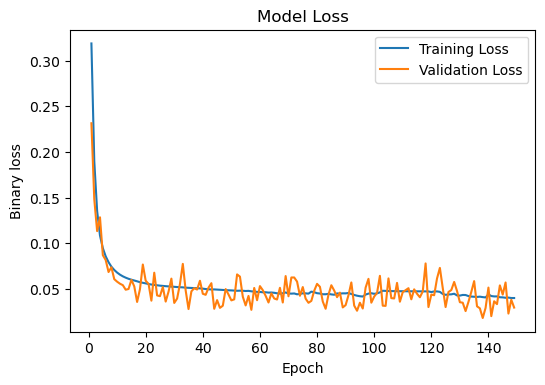

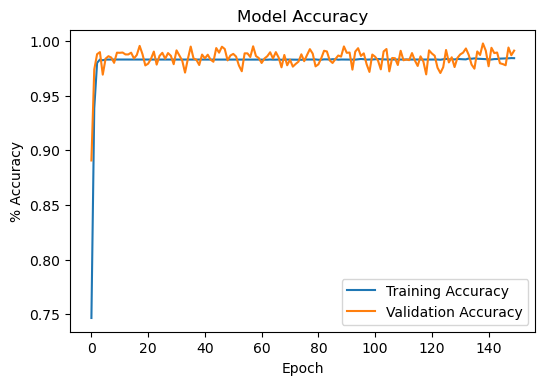

In [52]:
import matplotlib.pyplot as plt
#earlyStopEpoch = epochs
earlyStopEpoch = 150
# Plot the result  
plt.figure(dpi=100)       
plt.plot(range(1,earlyStopEpoch),trackGNNLSTM[1:earlyStopEpoch,0], label = "Training Loss")
plt.plot(range(1,earlyStopEpoch),trackGNNLSTM[1:earlyStopEpoch,2], label = "Validation Loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Binary loss')
plt.title('Model Loss')
#plt.yscale('log')
#plt.show()
# plt.savefig("Plot/Loss_{}.png".format(bus))

plt.figure(dpi=100) 
plt.plot(range(0,earlyStopEpoch),trackGNNLSTM[0:earlyStopEpoch,1], label = "Training Accuracy")
plt.plot(range(0,earlyStopEpoch),trackGNNLSTM[0:earlyStopEpoch,3], label = "Validation Accuracy")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("% Accuracy")
plt.title('Model Accuracy')
# plt.savefig("Plot/Accuracy_{}.png".format(bus))

In [36]:
modelGNNLSTM.set_weights(best_weightsGNNLSTM)  # Load best model
loader_teGNNLSTM = MixedLoader(data_teGNNLSTM, batch_size=1, shuffle = False, epochs=1)
predCmt = np.zeros([len(data_teGNNLSTM),nBus,nPrd])
targCmt = np.zeros([len(data_teGNNLSTM),nBus,nPrd])
targGCmt = np.zeros([len(data_teGNNLSTM),nGen,nPrd])
j = 0

for i in range(len(data_teGNNLSTM)):
    targCmt[i,:,:] = data_teGNNLSTM[i].y[:,:]
    for g in range(nGen):
        targGCmt[i,g,:] = targCmt[i,gBus[g]-1,:]
    
for batch_va in loader_teGNNLSTM:   
    pred_va, targ_va = modelGNNLSTM(*batch_va, training=False)
    
    for n in range(nBus):
        for t in range(nPrd):
            predCmt [j,n,t] = pred_va[0,n,t]
            #targ [j,n,t] = targ_va[0,n,t] 
    j = j + 1

m = predCmt.shape[0]
Y_test_hackFullBusCmt = np.zeros((m,nBus,nPrd))
P = 0.5

for i in range(m):
    for j in range(nBus):
        for t in range(nPrd):
            # Convert probabilities A[0,i] to actual predictions p[0,i]
            if predCmt[i,j,t] >= P:
                Y_test_hackFullBusCmt[i, j,t] = 1

            else:
                Y_test_hackFullBusCmt[i, j,t] = 0
print("test accuracy: {} %".format(100 - np.mean(np.abs(targCmt - Y_test_hackFullBusCmt)) * 100))

C:\Users\aramesh4\Anaconda3\lib\site-packages\spektral\layers\convolutional\ecc_conv.py:162: UserWarning: Casting dense adjacency matrix to SparseTensor.This can be an expensive operation. 
  warnings.warn(


test accuracy: 90.07458847736626 %


In [38]:
#########################################################################################################
# EDGE PREDICTION
#########################################################################################################

# Create graph files and save them into the folder GNN_Graph
path = DataDir + "/Spatio-Temporal_EdgePrediction_" + SysName + "_GeneratedGraphs"

for i in range(nSamples):
    filename = os.path.join(path,f'GNN_{i}')
    # np.savez_compressed(filename, x = NF[i,:,:], e = EF[i,:,:], y = Label[i,:,:])#, a = sp_matrix_to_sp_tensor(AM_sparse)) # EF [edges,features] mixed loader AM separate
    # np.savez_compressed(filename, x = NF[i,:,:], e = EF2[i,:,:,:], y = Label[i,:,:]) # EF [Nodes,nodes,features] mixed loader AM separate
    # np.savez_compressed(filename, x = NF[i,:,:], a = AM_sparse, e = EF[i,:,:], y = Label[i,:]) # EF [edges,features] AM_sparse for single, disjoint or batch
    # np.savez_compressed(filename, x = NF[i,:,:], a = AM_dense, e = EF[i,:,:], y = Label[i,:]) # EF [edges,features] AM_dense for single, disjoint or batch
    # np.savez_compressed(filename, x = NF[i,:,:], a = AM_sparse, e = EF2[i,:,:,:], y = Label[i,:]) # EF [Nodes,nodes,features] AM_sparse for single, disjoint or batch
    np.savez_compressed(filename, x = NF[i,:,:], a = AM_dense, e = EF2[i,:,:,:], y = Label2Flow[i,:,:,:]) # EF [Nodes,nodes,features] AM_dense for single, disjoint or batch

In [39]:
# Define Graphs_Data class as a container for all graph files
class Graphs_DataEP(spektral.data.dataset.Dataset):
    def read(self):
        output = []
        path = DataDir + "/Spatio-Temporal_EdgePrediction_" + SysName + "_GeneratedGraphs"
        # Load data from npz files into read()
        for i in range(nSamples):
            graph = np.load(os.path.join(path, f'GNN_{i}.npz'))
            output.append(spektral.data.dataset.Graph(x=graph['x'], a = graph['a'], e=graph['e'], y=graph['y']))#, a = graph['a']))
            # y=spektral.utils.one_hot(graph['y']-1,2)))
            # a=graph['a']
            # a=sp.csr_matrix(graph['a'])

        return output

In [40]:
# Load Data
GNN_DataEP = Graphs_DataEP()

# Load adjacency matrix to dataset for mixed mode
#GNN_Data.a = AM_dense #sp_matrix_to_sp_tensor(AM_sparse)

In [41]:
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv1D, LSTM
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.metrics import categorical_accuracy,sparse_categorical_accuracy, binary_accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

from spektral.data import Dataset, Graph, MixedLoader, DisjointLoader, BatchLoader, PackedBatchLoader
from spektral.layers import XENetConvBatch

# Config
learning_rate = 0.003  # Learning rate
epochs = 75  # Number of training epochs
es_patience = 5  # Patience for early stopping
batch_sizes = 64  # Batch size
seed = 0
tf.random.set_seed(seed=seed)  # make weight initialization reproducible

dataEP = GNN_DataEP

################################################################################
# Build model
################################################################################
class GNNEP(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = XENetConvBatch(24, 24, 24, attention=True, node_activation="PReLU", edge_activation="PReLU", use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')
        self.conv2 = XENetConvBatch(24, 24, 24, attention=True, node_activation="PReLU", edge_activation="PReLU", use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')
        self.conv3 = XENetConvBatch(24, 24, 24, attention=True, node_activation="PReLU", edge_activation="PReLU", use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')
        self.lstm1 = LSTM((nBranch-n_llel), activation="tanh", recurrent_activation="sigmoid", use_bias=True, kernel_initializer="glorot_uniform", recurrent_initializer="orthogonal", bias_initializer="zeros",return_sequences=True)    
        # (stack_channels, node_channels, edge_channels, attention=True, node_activation=None, edge_activation=None, aggregate='sum', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
        self.drop  = Dropout(0.1)
        self.dense = Dense(dataEP.n_labels, activation="sigmoid")


    def call(self, inputs, labels):
        x, a, e = inputs
        x, e = self.conv1([x, a, e])
        x, e = self.conv2([x, a, e])
        
        output = self.dense(e)
        return output, labels


modelEP = GNNEP()
optimizer = Adam(learning_rate=learning_rate, decay = 1e-4)
loss_fn = BinaryCrossentropy()

################################################################################

def evaluateEP(loader):
    for batch_va in loader:
        pred_va, targ_va = modelEP(*batch_va, training=False)
        loss_va = loss_fn(targ_va, pred_va),
        acc_va = tf.reduce_mean(binary_accuracy(targ_va, pred_va)),
    return loss_va, acc_va

In [42]:
#data=data_temp
# Train/valid/test split
idxsEP = range(len(dataEP)) 
split_vaEP, split_teEP = int(0.70 * len(dataEP)), int(0.85 * len(dataEP))
idx_trEP, idx_vaEP, idx_teEP = np.split(idxsEP, [split_vaEP, split_teEP])
data_trEP = dataEP[idx_trEP]
data_vaEP = dataEP[idx_vaEP]
data_teEP = dataEP[idx_teEP]
#print (idx_te)
print(len(data_trEP))
print(len(data_vaEP))
print(len(data_teEP))

# Data loaders
loader_trEP = BatchLoader(data_trEP, batch_size=batch_sizes, epochs=epochs, shuffle = False)
loader_vaEP = BatchLoader(data_vaEP, batch_size=batch_sizes, shuffle = False, epochs=1)
loader_teEP = BatchLoader(data_teEP, batch_size=batch_sizes, shuffle = False, epochs=1)

1260
270
270


In [43]:
epoch = step = 0
best_val_loss = np.inf
best_val_acc = 0
best_weightsEP = None
patience = es_patience
results = []
step = 0
trackEP = np.zeros([epochs,4])

for batch in loader_trEP:
    step += 1
    # loss, acc = train_step(*batch)
    
    with tf.GradientTape() as tape:
        prediction, target = modelEP(*batch, training=True)
        loss = loss_fn(target, prediction) + sum(modelEP.losses)
    gradients = tape.gradient(loss, modelEP.trainable_variables, unconnected_gradients=tf.UnconnectedGradients.ZERO)
    optimizer.apply_gradients(zip(gradients, modelEP.trainable_variables))
    acc = tf.reduce_mean(binary_accuracy(target, prediction))
    results.append((loss, acc))
    
    #Print out result after every epoch
    if step == loader_trEP.steps_per_epoch: 
        
        # Compute validation loss and accuracy
        #loader_va = MixedLoader(data_va, batch_size=batch_sizes, shuffle = False, epochs=1)
        loader_vaEP = BatchLoader(data_vaEP, batch_size=batch_sizes, shuffle = False, epochs=1)
        val_loss, val_acc = evaluateEP(loader_vaEP)
        
        #Save loss and accuracy for plotting
        trackEP[epoch,:] = [ *np.mean(results, 0), *val_loss, *val_acc ]   
        
        step = 0
        epoch += 1        
        # Print out result for each epoch
        print(
            "Ep. {} - Loss: {:.5f} - Acc: {:.5f} - Val loss: {:.5f} - Val acc: {:.5f}".format(
                epoch, *np.mean(results, 0), *val_loss, *val_acc
            )
        )
        #print (np.mean(val_loss))
        # Check if loss improved for early stopping
        if val_loss[0] < best_val_loss:
            best_val_loss = val_loss
            patience = es_patience
            print("New best val_loss {:.3f}".format(*val_loss))
            best_weightsEP = modelEP.get_weights()
        else:
            patience -= 1
            if patience == 0:
                print("Early stopping (best val_loss: {})".format(best_val_loss))
                break
                
        results = []

modelEP.save("modelGNNLSTMEP")

Ep. 1 - Loss: 0.77460 - Acc: 0.98229 - Val loss: 0.65167 - Val acc: 0.98860
New best val_loss 0.652
Ep. 2 - Loss: 0.62797 - Acc: 0.99383 - Val loss: 0.60736 - Val acc: 0.99573
New best val_loss 0.607
Ep. 3 - Loss: 0.59305 - Acc: 0.99642 - Val loss: 0.57797 - Val acc: 0.99766
New best val_loss 0.578
Ep. 4 - Loss: 0.56559 - Acc: 0.99825 - Val loss: 0.55206 - Val acc: 0.99889
New best val_loss 0.552
Ep. 5 - Loss: 0.54121 - Acc: 0.99870 - Val loss: 0.52873 - Val acc: 0.99903
New best val_loss 0.529
Ep. 6 - Loss: 0.51868 - Acc: 0.99876 - Val loss: 0.50686 - Val acc: 0.99902
New best val_loss 0.507
Ep. 7 - Loss: 0.49737 - Acc: 0.99877 - Val loss: 0.48611 - Val acc: 0.99902
New best val_loss 0.486
Ep. 8 - Loss: 0.47713 - Acc: 0.99877 - Val loss: 0.46639 - Val acc: 0.99899
New best val_loss 0.466
Ep. 9 - Loss: 0.45787 - Acc: 0.99878 - Val loss: 0.44765 - Val acc: 0.99899
New best val_loss 0.448
Ep. 10 - Loss: 0.43957 - Acc: 0.99879 - Val loss: 0.42983 - Val acc: 0.99899
New best val_loss 0.430

INFO:tensorflow:Assets written to: modelGNNLSTMEP\assets


INFO:tensorflow:Assets written to: modelGNNLSTMEP\assets


In [44]:
################################################################################
# Evaluate model
################################################################################
modelEP.set_weights(best_weightsEP)  # Load best model
#loader_te = MixedLoader(data_te, batch_size=batch_sizes, shuffle = True, epochs=1)
loader_teEP = BatchLoader(data_teEP, batch_size=batch_sizes, shuffle = True, epochs=1)
test_loss, test_acc = evaluateEP(loader_teEP)
print("Done. Test loss: {:.5f}. Test acc: {:.5f}".format(*test_loss, *test_acc))

C:\Users\aramesh4\Anaconda3\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'Graphs_DataEP' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Done. Test loss: 0.07110. Test acc: 0.99898


Text(0.5, 1.0, 'Model Accuracy')

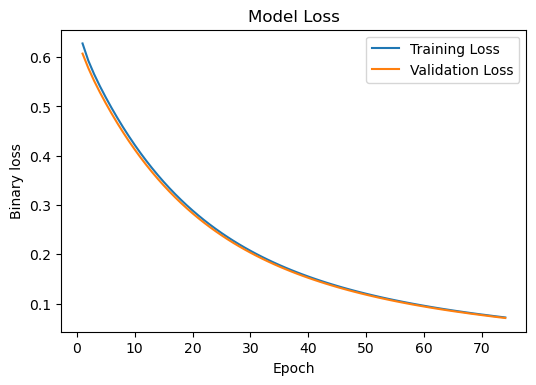

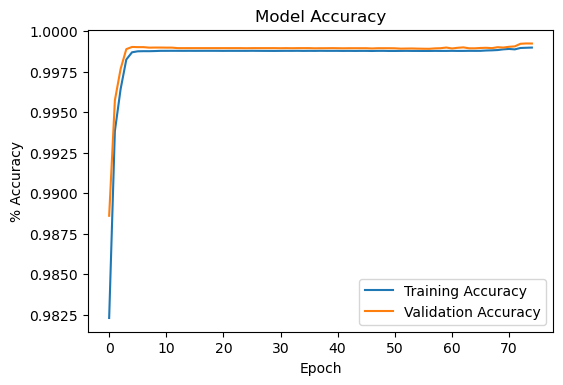

In [45]:
#earlyStopEpoch = epochs
earlyStopEpoch = 75
# Plot the result  
plt.figure(dpi=100)       
plt.plot(range(1,earlyStopEpoch),trackEP[1:earlyStopEpoch,0], label = "Training Loss")
plt.plot(range(1,earlyStopEpoch),trackEP[1:earlyStopEpoch,2], label = "Validation Loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Binary loss')
plt.title('Model Loss')
#plt.yscale('log')
# plt.savefig("Plot/Loss_{}.png".format(bus))

plt.figure(dpi=100) 
plt.plot(range(0,earlyStopEpoch),trackEP[0:earlyStopEpoch,1], label = "Training Accuracy")
plt.plot(range(0,earlyStopEpoch),trackEP[0:earlyStopEpoch,3], label = "Validation Accuracy")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("% Accuracy")
plt.title('Model Accuracy')
# plt.savefig("Plot/Accuracy_{}.png".format(bus))

In [46]:
modelEP.set_weights(best_weightsEP)  # Load best model
loader_teEP = BatchLoader(data_teEP, batch_size=1, shuffle = False, epochs=1)
predL = np.zeros([len(data_teEP),nBranch-n_llel,nPrd])
targL = np.zeros([len(data_teEP),nBus,nBus,nPrd])
targLB = np.zeros([len(data_teEP),nBranch-n_llel,nPrd])

j = 0

for i in range(len(data_teEP)):
    targL[i,:,:,:] = data_teEP[i].y[:,:,:]
    for k in range(nBranch-n_llel):
        targLB[i,k,:] = targL[i,int(fBus_llel[k,0])-1, int(tBus_llel[k,0])-1,:]
    
for batch_va in loader_teEP:   
    pred_va, targ_va = modelEP(*batch_va, training=False)
    
    for k in range(nBranch-n_llel):
        for t in range(nPrd):
            predL [j,k,t] = pred_va[0,int(fBus_llel[k,0])-1, int(tBus_llel[k,0])-1,t]
             
    j = j + 1
print (j)

m = predL.shape[0]
Y_test_hackFullEP = np.zeros((m,nBranch-n_llel,nPrd))
P = 0.5

for i in range(m):
    for k in range(nBranch-n_llel):
        for t in range(nPrd):
            # Convert probabilities A[0,i] to actual predictions p[0,i]
            if predL[i, k,t] >= P:
                Y_test_hackFullEP[i, k,t] = 1

            else:
                Y_test_hackFullEP[i, k,t] = 0
print("test accuracy: {} %".format(100 - np.mean(np.abs(targLB - Y_test_hackFullEP)) * 100))

270
test accuracy: 98.37463689179376 %


In [ ]:
#####################################################################
#### VERIFICATION USING OPTIMIZATION WITH ML PREDICTIONS STARTS HERE
#####################################################################

In [61]:
#####################################################################
#### B-Theta SCUC FORMULATION
#####################################################################
from pyomo.environ import *

# The pyomo abstract model for UC
model = AbstractModel()

Bus = []
for n in range(nBus):
    Bus.append(n + 1)

### set
model.BUS    = Set(initialize = Bus)                        #n
model.BRANCH = Set(initialize = Bra_data["branchNo"])       #k
model.GEN    = Set(initialize = Gen_data["genNo"])          #g

# Python set
# 24 hour time set
Time = []
for t in range(nPrd):
    Time.append(t + 1)
model.TIME = Set(initialize = Time)                         #t

### Param
#Bus param
def bus_num(model, n):
    return Bus[int(n-1)]
model.bus_num  = Param(model.BUS, initialize = bus_num)

# load_profile = rand_load(bus,Bus_data)
def bus_Pd(model, n, t):
    return load_profile[int(n-1),int(t-1)]
model.load_n_t   = Param(model.BUS, model.TIME, initialize = bus_Pd, mutable = True)

#Gen param
def gen_num(model, g):
    return Gen_data["genNo"][int(g-1)]
model.gen_num  = Param(model.GEN, initialize = gen_num)

def gen_bus(model, g):
    return Gen_data["genD_bus"][int(g-1)]
model.gen_bus  = Param(model.GEN, initialize = gen_bus)

def genD_minUP(model, g):
    return Gen_data["genD_minUP"][int(g-1)]
model.genD_minUP    = Param(model.GEN, initialize = genD_minUP)

def genD_minDN(model, g):
    return Gen_data["genD_minDN"][int(g-1)]
model.genD_minDN    = Param(model.GEN, initialize = genD_minDN)

def gen_Pmax(model, g):
    return Gen_data["genD_Pmax"][int(g-1)]
model.gen_Pmax = Param(model.GEN, initialize = gen_Pmax)

def gen_Pmin(model, g):
    return Gen_data["genD_Pmin"][int(g-1)]
model.gen_Pmin = Param(model.GEN, initialize = gen_Pmin)

def gen_cost_SU(model, g):
    return Gen_data["genC_Startup"][int(g-1)]
model.gen_cost_SU    = Param(model.GEN, initialize = gen_cost_SU)

def gen_cost_P(model, g):
    return Gen_data["genC_Cost"][int(g-1)]
model.gen_cost_P    = Param(model.GEN, initialize = gen_cost_P)

def gen_cost_NL(model, g):
    return Gen_data["genC_NLoad"][int(g-1)]
model.gen_cost_NL    = Param(model.GEN, initialize = gen_cost_NL)

def SPRamp(model, g):
    return Gen_data["SPRamp"][int(g-1)]
model.SPRamp    = Param(model.GEN, initialize = SPRamp)

def NSRamp(model, g):
    return Gen_data["NSRamp"][int(g-1)]
model.NSRamp    = Param(model.GEN, initialize = NSRamp)

def HRamp(model, g):
    return Gen_data["HRamp"][int(g-1)]
model.HRamp    = Param(model.GEN, initialize = HRamp)

def StartRamp(model, g):
    return Gen_data["StartRamp"][int(g-1)]
model.StartRamp    = Param(model.GEN, initialize = StartRamp)


#Branch param
def branch_num(model, k):
    return Bra_data["branchNo"][int(k-1)]
model.branch_num   = Param(model.BRANCH, initialize = branch_num)

def branch_fbus(model, k):
    return Bra_data["branch_fbus"][int(k-1)]
model.branch_fbus  = Param(model.BRANCH, initialize = branch_fbus)

def branch_tbus(model, k):
    return Bra_data["branch_tbus"][int(k-1)]
model.branch_tbus  = Param(model.BRANCH, initialize = branch_tbus)

def branch_b(model, k):
    return Bra_data["branch_b"][int(k-1)]
model.branch_b     = Param(model.BRANCH, initialize = branch_b)

def branch_rateA(model, k):
    return Bra_data["branch_rateA"][int(k-1)]
model.branch_rateA = Param(model.BRANCH, initialize = branch_rateA)

# Variable
# Gen_Time Var
model.p_g_t = Var(model.GEN, model.TIME)
model.u_g_t = Var(model.GEN, model.TIME, domain=Binary)
model.v_g_t = Var(model.GEN, model.TIME, domain=Binary)
model.r_g_t = Var(model.GEN, model.TIME)
# Line_Time Var
model.p_k_t = Var(model.BRANCH, model.TIME)
# Bus_Time Var
model.theta_n_t = Var(model.BUS, model.TIME)

# Objective function
def objfunction(model):
    obj = sum(
        model.gen_cost_P[g] * model.p_g_t[g, t] + model.gen_cost_NL[g] * model.u_g_t[g, t] + model.gen_cost_SU[g] *
        model.v_g_t[g, t] for g in model.GEN for t in model.TIME)
    return obj

model.cost = Objective(rule=objfunction, sense=minimize)

# # Generator initial u_g_t status
# def gen_Uinit_f(model, g):
#     return model.u_g_t[g, 0] == 0
# model.gen_Uinit_cons = Constraint(model.GEN, rule=gen_Uinit_f)

# Generator power and reserve constraints
# P_g_t minimum constraint
def gen_Pmin_f(model, g, t):
    return model.gen_Pmin[g] * model.u_g_t[g, t] <= model.p_g_t[g, t]

model.gen_Pmin_cons = Constraint(model.GEN, model.TIME, rule=gen_Pmin_f)

# P_g_t maximum constraint:
def gen_Pmax_f(model, g, t):
    return model.p_g_t[g, t] + model.r_g_t[g, t] <= model.gen_Pmax[g] * model.u_g_t[g, t]

model.gen_Pmax_cons = Constraint(model.GEN, model.TIME, rule=gen_Pmax_f)

# r_g_t ramping constraint 1:
def reserve_rr1_f(model, g, t):
    return model.r_g_t[g, t] <= model.SPRamp[g] * model.u_g_t[g, t]

model.reserve_rr1_cons = Constraint(model.GEN, model.TIME, rule=reserve_rr1_f)

# r_g_t ramping constraint 2:
def reserve_rr2_f(model, g, t):
    return model.r_g_t[g, t] >= 0

model.reserve_rr2_cons = Constraint(model.GEN, model.TIME, rule=reserve_rr2_f)

# total reserve constraint
def reserve_tot_f(model, g, t):
    reserve_tot_left = sum(model.r_g_t[g_1, t] for g_1 in model.GEN)
    reserve_tot_right = model.p_g_t[g, t] + model.r_g_t[g, t]
    return reserve_tot_left >= reserve_tot_right

model.reserve_tot_cons = Constraint(model.GEN, model.TIME, rule=reserve_tot_f)

# Generator Ramp up constraint
def gen_HrRampUp_f(model, g, t):
    if t == 1:
        return (model.p_g_t[g, 1] - model.p_g_t[g, nPrd] <= 
                model.HRamp[g]*model.u_g_t[g, nPrd] + model.StartRamp[g]*model.v_g_t[g, 1])
    else:
        return (model.p_g_t[g, t] - model.p_g_t[g, t-1] <= 
                model.HRamp[g]*model.u_g_t[g, t] + model.StartRamp[g]*model.v_g_t[g, t])

model.gen_HrRampUp_cons = Constraint(model.GEN, model.TIME, rule=gen_HrRampUp_f)

# Generator Ramp down constraint
def gen_HrRampDn_f(model, g, t):
    if t == 1:
        return (model.p_g_t[g, nPrd] - model.p_g_t[g, 1] <= 
                model.HRamp[g]*model.u_g_t[g, 1] + model.StartRamp[g]*(model.v_g_t[g, 1]-model.u_g_t[g, 1]
                                                                       +model.u_g_t[g, nPrd]))
    else:
        return (model.p_g_t[g, t-1] - model.p_g_t[g, t] <= 
                model.HRamp[g]*model.u_g_t[g, t] + model.StartRamp[g]*(model.v_g_t[g, t]-model.u_g_t[g, t]
                                                                       +model.u_g_t[g, t-1]))

model.gen_HrRampDn_cons = Constraint(model.GEN, model.TIME, rule=gen_HrRampDn_f)

# Binary constraints:

# Min up time constraint:
def Min_up_f(model, g, t):
    cPrd = t
    if t >= model.genD_minUP[g]:       
        min_up_left = sum(model.v_g_t[g, z] for z in range((cPrd-model.genD_minUP[g]+1),(cPrd+1)))
        min_dn_right = model.u_g_t[g, t]
        return min_up_left <=  min_dn_right   
    else:
        min_up_left_1 = sum(model.v_g_t[g, z1] for z1 in range((nPrd+cPrd-model.genD_minUP[g]+1),(nPrd+1)))
        min_up_left_2 = sum(model.v_g_t[g, z2] for z2 in range(1,(cPrd+1)))
        min_dn_right = model.u_g_t[g, t]
        return (min_up_left_1 + min_up_left_2) <=  min_dn_right

model.Min_up_f_cons = Constraint(model.GEN, model.TIME, rule=Min_up_f)

# Min dn time constraint:
def Min_dn_f(model, g, t):
    cPrd = t
    if t <= (nPrd - model.genD_minDN[g]):       
        min_up_left = sum(model.v_g_t[g, z] for z in range((cPrd + 1),(cPrd + model.genD_minDN[g]+1)))
        min_dn_right = 1 - model.u_g_t[g, t]
        return min_up_left <=  min_dn_right   
    else:
        min_up_left_1 = sum(model.v_g_t[g, z1] for z1 in range(1,(cPrd+model.genD_minDN[g]-nPrd+1)))
        min_up_left_2 = sum(model.v_g_t[g, z2] for z2 in range((cPrd+1),(nPrd+1)))
        min_dn_right = 1 - model.u_g_t[g, t]
        return (min_up_left_1 + min_up_left_2) <=  min_dn_right

model.Min_dn_f_cons = Constraint(model.GEN, model.TIME, rule=Min_dn_f)

# Start-up definition
def var_v_f(model, g, t):
    if t == 1:
        return model.v_g_t[g, 1] >= model.u_g_t[g, 1] - model.u_g_t[g, nPrd]
    else:
        return model.v_g_t[g, t] >= model.u_g_t[g, t] - model.u_g_t[g, t - 1]
model.var_v_cons = Constraint(model.GEN, model.TIME, rule=var_v_f)

def slack_f(model,t):
    return model.theta_n_t[1,t] == 0;
model.slack_cons = Constraint(model.TIME, rule=slack_f)

# Power flow constraint
def pf_theta_f(model, k, t):
    fbus_num = model.branch_fbus[k]
    tbus_num = model.branch_tbus[k]
    left_term = (model.theta_n_t[tbus_num, t] - model.theta_n_t[fbus_num, t]) * model.branch_b[k]
    return  left_term == (model.p_k_t[k, t]/100)
model.pf_theta_cons = Constraint(model.BRANCH, model.TIME, rule=pf_theta_f)

# Power flow min constraint:
def pf_min_f(model, k, t):
    return model.p_k_t[k, t] >= -1 * model.branch_rateA[k]  # relax line rating

model.pf_min_cons = Constraint(model.BRANCH, model.TIME, rule=pf_min_f)

# Power flow max constraint:
def pf_max_f(model, k, t):
    return model.p_k_t[k, t] <= 1 * model.branch_rateA[k]  # relax line rating

model.pf_max_cons = Constraint(model.BRANCH, model.TIME, rule=pf_max_f)

# Nodal balance constraint
def nodal_balance_f(model, n, t):
    nodal_balance_left = sum(model.p_g_t[g, t] for g in model.GEN if model.gen_bus[g] == n)
    nodal_balance_left += sum(model.p_k_t[k, t] for k in model.BRANCH if model.branch_tbus[k] == n)
    nodal_balance_left -= sum(model.p_k_t[k, t] for k in model.BRANCH if model.branch_fbus[k] == n)
    nodal_balance_right = model.load_n_t[n, t]
    
    return nodal_balance_left == nodal_balance_right

model.nodal_balance_cons = Constraint(model.BUS, model.TIME, rule=nodal_balance_f)

In [69]:
nTestSamples = len(data_teGNNLSTM)
N_data_Testing = np.zeros((nTestSamples,nBus,nPrd))

for i in range(nTestSamples):
    N_data_Testing[i,:,:] = data_teGNNLSTM[i].x[:,:]*100

In [71]:
### set the solver
from pyomo.opt import SolverFactory

solver = SolverFactory("solver\gurobi.exe")
solver.options.mipgap = 0.001

resultsFulBTheta = {}

### Suppress infeasible error warning
import logging
logging.getLogger('pyomo.core').setLevel(logging.ERROR)

### Run solver to verify test samples

for i in range(nTestSamples):
    load_profile = np.zeros([nBus,nPrd])
    load_profile = N_data_Testing[i,:,:]
    scucFul = model.create_instance()
    optOPFul = solver.solve(scucFul, tee=False)
    #resultsFul.append(optOP)
    solveResults = optOPFul.Solver._list
    resultsFulBTheta[i,0] = solveResults[0]["Termination condition"]
    resultsFulBTheta[i,1] = value(scucFul.cost)
    resultsFulBTheta[i,2] = solveResults[0].time
    ProbDescrip = optOPFul.Problem._list
    resultsFulBTheta[i,3] = ProbDescrip[0]["Number of constraints"]
    resultsFulBTheta[i,4] = ProbDescrip[0]["Number of variables"]

    if i%10 == 0:
        print (i)
        


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260


In [72]:
print (resultsFulBTheta)

{(0, 0): <TerminationCondition.optimal: 'optimal'>, (0, 1): 477125.89322788356, (0, 2): 0.8557829856872559, (0, 3): 6936, (0, 4): 2928, (1, 0): <TerminationCondition.optimal: 'optimal'>, (1, 1): 399813.1553747744, (1, 2): 0.2715420722961426, (1, 3): 6936, (1, 4): 2928, (2, 0): <TerminationCondition.optimal: 'optimal'>, (2, 1): 404501.71957740374, (2, 2): 0.2621753215789795, (2, 3): 6936, (2, 4): 2928, (3, 0): <TerminationCondition.optimal: 'optimal'>, (3, 1): 384733.585278291, (3, 2): 0.3436703681945801, (3, 3): 6936, (3, 4): 2928, (4, 0): <TerminationCondition.optimal: 'optimal'>, (4, 1): 395562.08854721696, (4, 2): 0.27013134956359863, (4, 3): 6936, (4, 4): 2928, (5, 0): <TerminationCondition.optimal: 'optimal'>, (5, 1): 458949.9599885622, (5, 2): 0.8128633499145508, (5, 3): 6936, (5, 4): 2928, (6, 0): <TerminationCondition.optimal: 'optimal'>, (6, 1): 524703.6336358897, (6, 2): 1.2397961616516113, (6, 3): 6936, (6, 4): 2928, (7, 0): <TerminationCondition.optimal: 'optimal'>, (7, 1):

In [73]:
j = 0
with open("resultsBThetaFul.csv", 'w') as f:
    for key in resultsFulBTheta.keys():
        j = j+1
        if j== 1:
            f.write("%s," % resultsFulBTheta[key])
        elif j== 2:
            f.write("%f," % resultsFulBTheta[key])
        elif j == 3:
            f.write("%f," % resultsFulBTheta[key])
        elif j == 4:
            f.write("%f," % resultsFulBTheta[key])
        elif j == 5:
            j=0
            f.write("%f \n" % resultsFulBTheta[key])

In [74]:
### set the solver
from pyomo.opt import SolverFactory

solver = SolverFactory("solver\gurobi.exe")
solver.options.mipgap = 0.001

PON = 0.90
POFF = 0.10
PTh = 0.50

resultsGenRedBtheta = {}
for i in range(nTestSamples):
    j=0
    load_profile = np.zeros([nBus,nPrd])
    load_profile = N_data_Testing[i,:,:]
    scucRed = model.create_instance()
    for g in range(nGen):
        for t in range(nPrd):
            if predCmt[i,gBus[g]-1, t] >= PON:
                scucRed.u_g_t[g+1,t+1].fix(1)
            elif predCmt[i, gBus[g]-1, t] <= POFF:
                scucRed.u_g_t[g+1,t+1].fix(0)
            else:
                j = j+1
    optOPRed = solver.solve(scucRed, tee=False)
    #resultsRed.append(optOP)
    solveResults = optOPRed.Solver._list
    resultsGenRedBtheta[i,0] = solveResults[0]["Termination condition"]
    if solveResults[0]["Termination condition"] != "optimal":
        resultsGenRedBtheta[i,1] = 0.0
    else:
        resultsGenRedBtheta[i,1] = value(scucRed.cost)
    resultsGenRedBtheta[i,2] = solveResults[0].time
    
    ProbDescrip = optOPRed.Problem._list
    resultsGenRedBtheta[i,3] = ProbDescrip[0]["Number of constraints"]
    resultsGenRedBtheta[i,4] = ProbDescrip[0]["Number of variables"]
    
    #print (j)
    if i%10 == 0:
        print (i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260


In [75]:
print (resultsGenRedBtheta) # just 1

{(0, 0): <TerminationCondition.optimal: 'optimal'>, (0, 1): 477125.8932278833, (0, 2): 0.7220315933227539, (0, 3): 6936, (0, 4): 2793, (1, 0): <TerminationCondition.optimal: 'optimal'>, (1, 1): 399813.15537477436, (1, 2): 0.22254681587219238, (1, 3): 6936, (1, 4): 2793, (2, 0): <TerminationCondition.optimal: 'optimal'>, (2, 1): 404501.71957740374, (2, 2): 0.2330939769744873, (2, 3): 6936, (2, 4): 2793, (3, 0): <TerminationCondition.optimal: 'optimal'>, (3, 1): 384733.58527829096, (3, 2): 0.2162461280822754, (3, 3): 6936, (3, 4): 2793, (4, 0): <TerminationCondition.optimal: 'optimal'>, (4, 1): 395562.0885472172, (4, 2): 0.23436546325683594, (4, 3): 6936, (4, 4): 2793, (5, 0): <TerminationCondition.optimal: 'optimal'>, (5, 1): 458949.95998856204, (5, 2): 0.31212830543518066, (5, 3): 6936, (5, 4): 2793, (6, 0): <TerminationCondition.optimal: 'optimal'>, (6, 1): 525516.0923579824, (6, 2): 0.4486668109893799, (6, 3): 6936, (6, 4): 2793, (7, 0): <TerminationCondition.optimal: 'optimal'>, (7,

In [76]:
j = 0
with open("resultsBThetaRedGen_Pon90e-2_Poff1e-2.csv", 'w') as f:
    for key in resultsGenRedBtheta.keys():
        j = j+1
        if j== 1:
            f.write("%s," % resultsGenRedBtheta[key])
        elif j== 2:
            f.write("%f," % resultsGenRedBtheta[key])
        elif j == 3:
            f.write("%f," % resultsGenRedBtheta[key])
        elif j== 4:
            f.write("%f," % resultsGenRedBtheta[key])
        elif j == 5:
            j=0
            f.write("%f \n" % resultsGenRedBtheta[key])

In [77]:
clubbedLines = []
clubbedLinesIdx = []
k_new = -1
clubbedLines.append(1)

for k in range(nBranch):
    k_new += 1
    if k>0:
        # remember to have a logic if for fbus =1 tbus =2 and fbus =2 tbus =1 also llel
        if ((fBus[k] == fBus[k-1]) and (tBus[k] == tBus[k-1])):
            k_new -= 1
            clubbedLines.remove(k)
            clubbedLines.append([k, k+1])
            clubbedLinesIdx.append(k_new)
            
        else:
            clubbedLines.append(k+1)

print (k_new)            
print (clubbedLines)
print (len(clubbedLines))
print (clubbedLines[23])
print (clubbedLines[24])
print (clubbedLines[24][0])
print (clubbedLines[24][1])

print (clubbedLinesIdx)

33
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, [25, 26], 27, 28, 29, 30, 31, [32, 33], [34, 35], [36, 37], 38]
34
24
[25, 26]
25
26
[24, 30, 31, 32]


In [78]:
solver = SolverFactory("solver\gurobi.exe")
solver.options.mipgap = 0.001

resultsRedEPBtheta = {}

### Suppress infeasible error warning
import logging
logging.getLogger('pyomo.core').setLevel(logging.ERROR)

### Run solver to verify test samples

for i in range(nTestSamples):
    
    
    load_profile = np.zeros([nBus,nPrd])
    load_profile = N_data_Testing[i,:,:]
    
    scucRed = model.create_instance()
    scucRed.pf_max_cons.deactivate()
    scucRed.pf_min_cons.deactivate()
    for k in range(nBranch-n_llel):
        for t in range(nPrd):
            if Y_test_hackFullEP[i,k,t] == 1:
                if k in clubbedLinesIdx:
                    scucRed.pf_max_cons[clubbedLines[k][0],:].activate()
                    scucRed.pf_min_cons[clubbedLines[k][0],:].activate()
                    scucRed.pf_max_cons[clubbedLines[k][1],:].activate()
                    scucRed.pf_min_cons[clubbedLines[k][1],:].activate()
                else:
                    scucRed.pf_max_cons[clubbedLines[k],:].activate()
                    scucRed.pf_min_cons[clubbedLines[k],:].activate()
                   
    optOPRed = solver.solve(scucRed, tee=False)
    #resultsFul.append(optOP)
    solveResults = optOPRed.Solver._list
    resultsRedEPBtheta[i,0] = solveResults[0]["Termination condition"]
    resultsRedEPBtheta[i,1] = value(scucRed.cost)
    resultsRedEPBtheta[i,2] = solveResults[0].time
    
    ProbDescrip = optOPRed.Problem._list
    resultsRedEPBtheta[i,3] = ProbDescrip[0]["Number of constraints"]
    resultsRedEPBtheta[i,4] = ProbDescrip[0]["Number of variables"]

    if i%10 == 0:
        print (i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260


In [79]:
j = 0
with open("resultsBThetaRedBra.csv", 'w') as f:
    for key in resultsRedEPBtheta.keys():
        j = j+1
        if j== 1:
            f.write("%s," % resultsRedEPBtheta[key])
        elif j== 2:
            f.write("%f," % resultsRedEPBtheta[key])
        elif j == 3:
            f.write("%f," % resultsRedEPBtheta[key])
        elif j== 4:
            f.write("%f," % resultsRedEPBtheta[key])
        elif j == 5:
            j=0
            f.write("%f \n" % resultsRedEPBtheta[key]) 

In [80]:
solver = SolverFactory("solver\gurobi.exe")
solver.options.mipgap = 0.001

resultsGenBraRedBtheta = {}

### Suppress infeasible error warning
import logging
logging.getLogger('pyomo.core').setLevel(logging.ERROR)

### Run solver to verify test samples

for i in range(nTestSamples):
    
    
    load_profile = np.zeros([nBus,nPrd])
    load_profile = N_data_Testing[i,:,:]
    
    scucRed = model.create_instance()
    scucRed.pf_max_cons.deactivate()
    scucRed.pf_min_cons.deactivate()
    for k in range(nBranch-n_llel):
        for t in range(nPrd):
            if Y_test_hackFullEP[i,k,t] == 1:
                if k in clubbedLinesIdx:
                    scucRed.pf_max_cons[clubbedLines[k][0],:].activate()
                    scucRed.pf_min_cons[clubbedLines[k][0],:].activate()
                    scucRed.pf_max_cons[clubbedLines[k][1],:].activate()
                    scucRed.pf_min_cons[clubbedLines[k][1],:].activate()
                else:
                    scucRed.pf_max_cons[clubbedLines[k],:].activate()
                    scucRed.pf_min_cons[clubbedLines[k],:].activate()
    j = 0
    for g in range(nGen):
        for t in range(nPrd):
            if predCmt[i,gBus[g]-1, t] >= PON:
                scucRed.u_g_t[g+1,t+1].fix(1)
            elif predCmt[i, gBus[g]-1, t] <= POFF:
                scucRed.u_g_t[g+1,t+1].fix(0)
            else:
                j = j+1
    optOPRed = solver.solve(scucRed, tee=False)
    #resultsFul.append(optOP)
    solveResults = optOPRed.Solver._list
    resultsGenBraRedBtheta[i,0] = solveResults[0]["Termination condition"]
    if solveResults[0]["Termination condition"] != "optimal":
        resultsGenBraRedBtheta[i,1] = 0.0
    else:
        resultsGenBraRedBtheta[i,1] = value(scucRed.cost)
    resultsGenBraRedBtheta[i,2] = solveResults[0].time
    
    ProbDescrip = optOPRed.Problem._list
    resultsGenBraRedBtheta[i,3] = ProbDescrip[0]["Number of constraints"]
    resultsGenBraRedBtheta[i,4] = ProbDescrip[0]["Number of variables"]

    if i%10 == 0:
        print (i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260


In [81]:
j = 0
with open("resultsBThetaRedGenBra.csv", 'w') as f:
    for key in resultsGenBraRedBtheta.keys():
        j = j+1
        if j== 1:
            f.write("%s," % resultsGenBraRedBtheta[key])
        elif j== 2:
            f.write("%f," % resultsGenBraRedBtheta[key])
        elif j == 3:
            f.write("%f," % resultsGenBraRedBtheta[key])
        elif j== 4:
            f.write("%f," % resultsGenBraRedBtheta[key])
        elif j == 5:
            j=0
            f.write("%f \n" % resultsGenBraRedBtheta[key])

In [82]:
#####################################################################
#### PTDF SCUC FORMULATION
#####################################################################
ptdf = loadtxt("PTDF_Matrix.csv", delimiter=',')

slackBusNode = 0 
print(ptdf)

[[ 0.00000000e+00 -9.42942255e-01 -3.39370314e-01 -6.84424729e-01
  -2.09710172e-01 -5.51262056e-01 -4.49774282e-01 -4.49774282e-01
  -4.72726099e-01 -4.26822466e-01 -4.37992282e-01 -4.40335906e-01
  -4.36533176e-01 -4.27878611e-01 -4.06931291e-01 -4.13671366e-01
  -4.11298579e-01 -4.10193410e-01 -4.19350849e-01 -4.24289535e-01
  -4.09167180e-01 -4.10004954e-01 -4.27005814e-01 -3.81569074e-01]
 [ 0.00000000e+00 -2.25172790e-02 -4.45043678e-01 -1.49356211e-01
  -8.68468190e-02 -1.39570439e-01 -2.14991501e-01 -2.14991501e-01
  -2.53223939e-01 -1.76759063e-01 -2.39166645e-01 -2.34274242e-01
  -2.42212582e-01 -2.60279309e-01 -3.04007622e-01 -2.89937464e-01
  -2.94890744e-01 -2.97197827e-01 -2.78081331e-01 -2.67771641e-01
  -2.99340120e-01 -2.97591235e-01 -2.62101306e-01 -3.56952195e-01]
 [ 0.00000000e+00 -3.45404670e-02 -2.15586008e-01 -1.66219060e-01
  -7.03443009e-01 -3.09167504e-01 -3.35234217e-01 -3.35234217e-01
  -2.74049962e-01 -3.96418472e-01 -3.22841073e-01 -3.25389852e-01
  -3.212

In [83]:
from pyomo.environ import *

# The pyomo abstract model for UC
modelPTDF = AbstractModel()

Bus = []
for n in range(nBus):
    Bus.append(n + 1)

### set
modelPTDF.BUS    = Set(initialize = Bus)                        #n
modelPTDF.BRANCH = Set(initialize = Bra_data["branchNo"])       #k
modelPTDF.GEN    = Set(initialize = Gen_data["genNo"])          #g

# Python set
# 24 hour time set
Time = []
for t in range(nPrd):
    Time.append(t + 1)
modelPTDF.TIME = Set(initialize = Time)                         #t

### Param
#Bus param
def bus_num(modelPTDF, n):
    return Bus[int(n-1)]
modelPTDF.bus_num  = Param(modelPTDF.BUS, initialize = bus_num)

# load_profile = rand_load(bus,Bus_data)
def bus_Pd(modelPTDF, n, t):
    return load_profile[int(n-1),int(t-1)]
modelPTDF.load_n_t   = Param(modelPTDF.BUS, modelPTDF.TIME, initialize = bus_Pd, mutable = True)

#Gen param
def gen_num(modelPTDF, g):
    return Gen_data["genNo"][int(g-1)]
modelPTDF.gen_num  = Param(modelPTDF.GEN, initialize = gen_num)

def gen_bus(modelPTDF, g):
    return Gen_data["genD_bus"][int(g-1)]
modelPTDF.gen_bus  = Param(modelPTDF.GEN, initialize = gen_bus)

def genD_minUP(modelPTDF, g):
    return Gen_data["genD_minUP"][int(g-1)]
modelPTDF.genD_minUP    = Param(modelPTDF.GEN, initialize = genD_minUP)

def genD_minDN(modelPTDF, g):
    return Gen_data["genD_minDN"][int(g-1)]
modelPTDF.genD_minDN    = Param(modelPTDF.GEN, initialize = genD_minDN)

def gen_Pmax(modelPTDF, g):
    return Gen_data["genD_Pmax"][int(g-1)]
modelPTDF.gen_Pmax = Param(modelPTDF.GEN, initialize = gen_Pmax)

def gen_Pmin(modelPTDF, g):
    return Gen_data["genD_Pmin"][int(g-1)]
modelPTDF.gen_Pmin = Param(modelPTDF.GEN, initialize = gen_Pmin)

def gen_cost_SU(modelPTDF, g):
    return Gen_data["genC_Startup"][int(g-1)]
modelPTDF.gen_cost_SU    = Param(modelPTDF.GEN, initialize = gen_cost_SU)

def gen_cost_P(modelPTDF, g):
    return Gen_data["genC_Cost"][int(g-1)]
modelPTDF.gen_cost_P    = Param(modelPTDF.GEN, initialize = gen_cost_P)

def gen_cost_NL(modelPTDF, g):
    return Gen_data["genC_NLoad"][int(g-1)]
modelPTDF.gen_cost_NL    = Param(modelPTDF.GEN, initialize = gen_cost_NL)

def SPRamp(modelPTDF, g):
    return Gen_data["SPRamp"][int(g-1)]
modelPTDF.SPRamp    = Param(modelPTDF.GEN, initialize = SPRamp)

def NSRamp(modelPTDF, g):
    return Gen_data["NSRamp"][int(g-1)]
modelPTDF.NSRamp    = Param(modelPTDF.GEN, initialize = NSRamp)

def HRamp(modelPTDF, g):
    return Gen_data["HRamp"][int(g-1)]
modelPTDF.HRamp    = Param(modelPTDF.GEN, initialize = HRamp)

def StartRamp(modelPTDF, g):
    return Gen_data["StartRamp"][int(g-1)]
modelPTDF.StartRamp    = Param(modelPTDF.GEN, initialize = StartRamp)


#Branch param
def branch_num(modelPTDF, k):
    return Bra_data["branchNo"][int(k-1)]
modelPTDF.branch_num   = Param(modelPTDF.BRANCH, initialize = branch_num)

def branch_fbus(modelPTDF, k):
    return Bra_data["branch_fbus"][int(k-1)]
modelPTDF.branch_fbus  = Param(modelPTDF.BRANCH, initialize = branch_fbus)

def branch_tbus(modelPTDF, k):
    return Bra_data["branch_tbus"][int(k-1)]
modelPTDF.branch_tbus  = Param(modelPTDF.BRANCH, initialize = branch_tbus)

def branch_b(modelPTDF, k):
    return Bra_data["branch_b"][int(k-1)]
modelPTDF.branch_b     = Param(modelPTDF.BRANCH, initialize = branch_b)

def branch_rateA(modelPTDF, k):
    return Bra_data["branch_rateA"][int(k-1)]
modelPTDF.branch_rateA = Param(modelPTDF.BRANCH, initialize = branch_rateA)

# Variable
# Gen_Time Var
modelPTDF.p_g_t = Var(modelPTDF.GEN, modelPTDF.TIME)
modelPTDF.u_g_t = Var(modelPTDF.GEN, modelPTDF.TIME, domain=Binary)
modelPTDF.v_g_t = Var(modelPTDF.GEN, modelPTDF.TIME, domain=Binary)
modelPTDF.r_g_t = Var(modelPTDF.GEN, modelPTDF.TIME)
# Line_Time Var
modelPTDF.p_k_t = Var(modelPTDF.BRANCH, modelPTDF.TIME)

# Objective function
def objfunction(modelPTDF):
    obj = sum(
        modelPTDF.gen_cost_P[g] * modelPTDF.p_g_t[g, t] + modelPTDF.gen_cost_NL[g] * modelPTDF.u_g_t[g, t] 
        + modelPTDF.gen_cost_SU[g] * modelPTDF.v_g_t[g, t] for g in modelPTDF.GEN for t in modelPTDF.TIME)
    return obj

modelPTDF.cost = Objective(rule=objfunction, sense=minimize)

# Generator power and reserve constraints
# P_g_t minimum constraint
def gen_Pmin_f(modelPTDF, g, t):
    return modelPTDF.gen_Pmin[g] * modelPTDF.u_g_t[g, t] <= modelPTDF.p_g_t[g, t]

modelPTDF.gen_Pmin_cons = Constraint(modelPTDF.GEN, modelPTDF.TIME, rule=gen_Pmin_f)

# P_g_t maximum constraint:
def gen_Pmax_f(modelPTDF, g, t):
    return modelPTDF.p_g_t[g, t] + modelPTDF.r_g_t[g, t] <= modelPTDF.gen_Pmax[g] * modelPTDF.u_g_t[g, t]

modelPTDF.gen_Pmax_cons = Constraint(modelPTDF.GEN, modelPTDF.TIME, rule=gen_Pmax_f)

# r_g_t ramping constraint 1:
def reserve_rr1_f(modelPTDF, g, t):
    return modelPTDF.r_g_t[g, t] <= modelPTDF.SPRamp[g] * modelPTDF.u_g_t[g, t]

modelPTDF.reserve_rr1_cons = Constraint(modelPTDF.GEN, modelPTDF.TIME, rule=reserve_rr1_f)

# r_g_t ramping constraint 2:
def reserve_rr2_f(modelPTDF, g, t):
    return modelPTDF.r_g_t[g, t] >= 0

modelPTDF.reserve_rr2_cons = Constraint(modelPTDF.GEN, modelPTDF.TIME, rule=reserve_rr2_f)

# total reserve constraint
def reserve_tot_f(modelPTDF, g, t):
    reserve_tot_left = sum(modelPTDF.r_g_t[g_1, t] for g_1 in modelPTDF.GEN)
    reserve_tot_right = modelPTDF.p_g_t[g, t] + modelPTDF.r_g_t[g, t]
    return reserve_tot_left >= reserve_tot_right

modelPTDF.reserve_tot_cons = Constraint(modelPTDF.GEN, modelPTDF.TIME, rule=reserve_tot_f)

# Generator Ramp up constraint
def gen_HrRampUp_f(modelPTDF, g, t):
    if t == 1:
        return (modelPTDF.p_g_t[g, 1] - modelPTDF.p_g_t[g, nPrd] <= 
                modelPTDF.HRamp[g]*modelPTDF.u_g_t[g, nPrd] + modelPTDF.StartRamp[g]*modelPTDF.v_g_t[g, 1])
    else:
        return (modelPTDF.p_g_t[g, t] - modelPTDF.p_g_t[g, t-1] <= 
                modelPTDF.HRamp[g]*modelPTDF.u_g_t[g, t] + modelPTDF.StartRamp[g]*modelPTDF.v_g_t[g, t])

modelPTDF.gen_HrRampUp_cons = Constraint(modelPTDF.GEN, modelPTDF.TIME, rule=gen_HrRampUp_f)

# Generator Ramp down constraint
def gen_HrRampDn_f(modelPTDF, g, t):
    if t == 1:
        return (modelPTDF.p_g_t[g, nPrd] - modelPTDF.p_g_t[g, 1] <= 
                modelPTDF.HRamp[g]*modelPTDF.u_g_t[g, 1] + modelPTDF.StartRamp[g]*(modelPTDF.v_g_t[g, 1]-modelPTDF.u_g_t[g, 1]
                                                                       +modelPTDF.u_g_t[g, nPrd]))
    else:
        return (modelPTDF.p_g_t[g, t-1] - modelPTDF.p_g_t[g, t] <= 
                modelPTDF.HRamp[g]*modelPTDF.u_g_t[g, t] + modelPTDF.StartRamp[g]*(modelPTDF.v_g_t[g, t]-modelPTDF.u_g_t[g, t]
                                                                       +modelPTDF.u_g_t[g, t-1]))

modelPTDF.gen_HrRampDn_cons = Constraint(modelPTDF.GEN, modelPTDF.TIME, rule=gen_HrRampDn_f)

# Binary constraints:

# Min up time constraint:
def Min_up_f(modelPTDF, g, t):
    cPrd = t
    if t >= modelPTDF.genD_minUP[g]:       
        min_up_left = sum(modelPTDF.v_g_t[g, z] for z in range((cPrd-modelPTDF.genD_minUP[g]+1),(cPrd+1)))
        min_dn_right = modelPTDF.u_g_t[g, t]
        return min_up_left <=  min_dn_right   
    else:
        min_up_left_1 = sum(modelPTDF.v_g_t[g, z1] for z1 in range((nPrd+cPrd-modelPTDF.genD_minUP[g]+1),(nPrd+1)))
        min_up_left_2 = sum(modelPTDF.v_g_t[g, z2] for z2 in range(1,(cPrd+1)))
        min_dn_right = modelPTDF.u_g_t[g, t]
        return (min_up_left_1 + min_up_left_2) <=  min_dn_right

modelPTDF.Min_up_f_cons = Constraint(modelPTDF.GEN, modelPTDF.TIME, rule=Min_up_f)

# Min dn time constraint:
def Min_dn_f(modelPTDF, g, t):
    cPrd = t
    if t <= (nPrd - modelPTDF.genD_minDN[g]):       
        min_up_left = sum(modelPTDF.v_g_t[g, z] for z in range((cPrd + 1),(cPrd + modelPTDF.genD_minDN[g]+1)))
        min_dn_right = 1 - modelPTDF.u_g_t[g, t]
        return min_up_left <=  min_dn_right   
    else:
        min_up_left_1 = sum(modelPTDF.v_g_t[g, z1] for z1 in range(1,(cPrd+modelPTDF.genD_minDN[g]-nPrd+1)))
        min_up_left_2 = sum(modelPTDF.v_g_t[g, z2] for z2 in range((cPrd+1),(nPrd+1)))
        min_dn_right = 1 - modelPTDF.u_g_t[g, t]
        return (min_up_left_1 + min_up_left_2) <=  min_dn_right

modelPTDF.Min_dn_f_cons = Constraint(modelPTDF.GEN, modelPTDF.TIME, rule=Min_dn_f)

# Start-up definition
def var_v_f(modelPTDF, g, t):
    if t == 1:
        return modelPTDF.v_g_t[g, 1] >= modelPTDF.u_g_t[g, 1] - modelPTDF.u_g_t[g, nPrd]
    else:
        return modelPTDF.v_g_t[g, t] >= modelPTDF.u_g_t[g, t] - modelPTDF.u_g_t[g, t - 1]
modelPTDF.var_v_cons = Constraint(modelPTDF.GEN, modelPTDF.TIME, rule=var_v_f)

#slack initialize column with bus 1 as 0 in ptdf matrix

# Power flow constraint
#PTDF version
def pf_ptdf_f(modelPTDF,k,t):
    expr = modelPTDF.p_k_t[k,t] - sum(modelPTDF.p_g_t[g,t] * ptdf[k-1,int(modelPTDF.gen_bus[g] - 1)] for g in modelPTDF.GEN) + sum(modelPTDF.load_n_t[n,t] * ptdf[k-1,n-1] for n in modelPTDF.BUS)
    return expr == 0
modelPTDF.pf_ptdf_cons = Constraint(modelPTDF.BRANCH,modelPTDF.TIME,rule = pf_ptdf_f)


# Power flow min constraint:
def pf_min_f(modelPTDF, k, t):
    return modelPTDF.p_k_t[k, t] >= -1 * modelPTDF.branch_rateA[k]  # relax line rating

modelPTDF.pf_min_cons = Constraint(modelPTDF.BRANCH, modelPTDF.TIME, rule=pf_min_f)

# Power flow max constraint:
def pf_max_f(modelPTDF, k, t):
    return modelPTDF.p_k_t[k, t] <= 1 * modelPTDF.branch_rateA[k]  # relax line rating

modelPTDF.pf_max_cons = Constraint(modelPTDF.BRANCH, modelPTDF.TIME, rule=pf_max_f)

# Nodal balance constraint
def nodal_balance_f(modelPTDF, t):
    nodal_balance_left = sum(modelPTDF.p_g_t[g, t] for g in modelPTDF.GEN)
    #nodal_balance_left += sum(modelPTDF.p_k_t[k, t] for k in modelPTDF.BRANCH if modelPTDF.branch_tbus[k] == n)
    #nodal_balance_left -= sum(modelPTDF.p_k_t[k, t] for k in modelPTDF.BRANCH if modelPTDF.branch_fbus[k] == n)
    nodal_balance_right = sum(modelPTDF.load_n_t[n, t] for n in modelPTDF.BUS)
    
    return nodal_balance_left == nodal_balance_right
modelPTDF.nodal_balance_cons = Constraint(modelPTDF.TIME, rule=nodal_balance_f)

In [84]:
### set the solver
from pyomo.opt import SolverFactory

solver = SolverFactory("solver\gurobi.exe")
solver.options.mipgap = 0.001

resultsFulPTDF = {}

### Suppress infeasible error warning
import logging
logging.getLogger('pyomo.core').setLevel(logging.ERROR)

for i in range(nTestSamples):
    
    load_profile = np.zeros([nBus,nPrd])
    load_profile = N_data_Testing[i,:,:]
    scucFulPTDF = modelPTDF.create_instance()
    optOPFulPTDF = solver.solve(scucFulPTDF, tee=False)
    
    solveResults = optOPFulPTDF.Solver._list
    
    resultsFulPTDF[i,0] = solveResults[0]["Termination condition"]
    resultsFulPTDF[i,1] = value(scucFulPTDF.cost)
    resultsFulPTDF[i,2] = solveResults[0].time
    
    ProbDescrip = optOPFulPTDF.Problem._list
    resultsFulPTDF[i,3] = ProbDescrip[0]["Number of constraints"]
    resultsFulPTDF[i,4] = ProbDescrip[0]["Number of variables"]

    if i%10 == 0:
        print (i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260


In [85]:
print (resultsFulPTDF)

{(0, 0): <TerminationCondition.optimal: 'optimal'>, (0, 1): 477531.37092910043, (0, 2): 0.9583740234375, (0, 3): 6360, (0, 4): 2352, (1, 0): <TerminationCondition.optimal: 'optimal'>, (1, 1): 400010.4862881836, (1, 2): 0.20989060401916504, (1, 3): 6360, (1, 4): 2352, (2, 0): <TerminationCondition.optimal: 'optimal'>, (2, 1): 404705.37691687007, (2, 2): 0.22136974334716797, (2, 3): 6360, (2, 4): 2352, (3, 0): <TerminationCondition.optimal: 'optimal'>, (3, 1): 384878.7171157708, (3, 2): 0.23180866241455078, (3, 3): 6360, (3, 4): 2352, (4, 0): <TerminationCondition.optimal: 'optimal'>, (4, 1): 395743.3233350817, (4, 2): 0.22365045547485352, (4, 3): 6360, (4, 4): 2352, (5, 0): <TerminationCondition.optimal: 'optimal'>, (5, 1): 459227.46987289534, (5, 2): 0.31246280670166016, (5, 3): 6360, (5, 4): 2352, (6, 0): <TerminationCondition.optimal: 'optimal'>, (6, 1): 525317.4001405715, (6, 2): 1.0083448886871338, (6, 3): 6360, (6, 4): 2352, (7, 0): <TerminationCondition.optimal: 'optimal'>, (7, 1

In [86]:
j = 0
with open("resultsPTDFFul.csv", 'w') as f:
    for key in resultsFulPTDF.keys():
        j = j+1
        if j== 1:
            f.write("%s," % resultsFulPTDF[key])
        elif j== 2:
            f.write("%f," % resultsFulPTDF[key])
        elif j== 3:
            f.write("%f," % resultsFulPTDF[key])
        elif j== 4:
            f.write("%f," % resultsFulPTDF[key])
        elif j == 5:
            j=0
            f.write("%f \n" % resultsFulPTDF[key])

In [87]:
### set the solver
from pyomo.opt import SolverFactory

solver = SolverFactory("solver\gurobi.exe")
solver.options.mipgap = 0.001

PON = 0.90
POFF = 0.10
PTh = 0.50

resultsGenRedPTDF = {}
for i in range(nTestSamples):
    j=0
    load_profile = np.zeros([nBus,nPrd])
    load_profile = N_data_Testing[i,:,:]
    scucRed = modelPTDF.create_instance()
    for g in range(nGen):
        for t in range(nPrd):
            if predCmt[i,gBus[g]-1, t] >= PON:
                scucRed.u_g_t[g+1,t+1].fix(1)
            elif predCmt[i, gBus[g]-1, t] <= POFF:
                scucRed.u_g_t[g+1,t+1].fix(0)
            else:
                j = j+1
    optOPRed = solver.solve(scucRed, tee=False)
    
    solveResults = optOPRed.Solver._list
    resultsGenRedPTDF[i,0] = solveResults[0]["Termination condition"]
    if solveResults[0]["Termination condition"] != "optimal":
        resultsGenRedPTDF[i,1] = 0.0
    else:
        resultsGenRedPTDF[i,1] = value(scucRed.cost)
    resultsGenRedPTDF[i,2] = solveResults[0].time
    
    ProbDescrip = optOPRed.Problem._list
    resultsGenRedPTDF[i,3] = ProbDescrip[0]["Number of constraints"]
    resultsGenRedPTDF[i,4] = ProbDescrip[0]["Number of variables"]
    
    #print (j)
    if i%10 == 0:
        print (i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260


In [88]:
j = 0
with open("resultsPTDFRedGen.csv", 'w') as f:
    for key in resultsGenRedPTDF.keys():
        j = j+1
        if j== 1:
            f.write("%s," % resultsGenRedPTDF[key])
        elif j== 2:
            f.write("%f," % resultsGenRedPTDF[key])
        elif j== 3:
            f.write("%f," % resultsGenRedPTDF[key])
        elif j== 4:
            f.write("%f," % resultsGenRedPTDF[key])
        elif j == 5:
            j=0
            f.write("%f \n" % resultsGenRedPTDF[key])

In [89]:
solver = SolverFactory("solver\gurobi.exe")
solver.options.mipgap = 0.001

resultsRedEPPTDF = {}

### Suppress infeasible error warning
import logging
logging.getLogger('pyomo.core').setLevel(logging.ERROR)

### Run solver to verify test samples

for i in range(nTestSamples):
    
    
    load_profile = np.zeros([nBus,nPrd])
    load_profile = N_data_Testing[i,:,:]
    
    scucRed = modelPTDF.create_instance()
    scucRed.pf_max_cons.deactivate()
    scucRed.pf_min_cons.deactivate()
    for k in range(nBranch-n_llel):
        for t in range(nPrd):
            if Y_test_hackFullEP[i,k,t] == 1:
                if k in clubbedLinesIdx:
                    scucRed.pf_max_cons[clubbedLines[k][0],:].activate()
                    scucRed.pf_min_cons[clubbedLines[k][0],:].activate()
                    scucRed.pf_max_cons[clubbedLines[k][1],:].activate()
                    scucRed.pf_min_cons[clubbedLines[k][1],:].activate()
                else:
                    scucRed.pf_max_cons[clubbedLines[k],:].activate()
                    scucRed.pf_min_cons[clubbedLines[k],:].activate()
                   
    optOPRed = solver.solve(scucRed, tee=False)
    #resultsFul.append(optOP)
    solveResults = optOPRed.Solver._list
    resultsRedEPPTDF[i,0] = solveResults[0]["Termination condition"]
    resultsRedEPPTDF[i,1] = value(scucRed.cost)
    resultsRedEPPTDF[i,2] = solveResults[0].time
    
    ProbDescrip = optOPRed.Problem._list
    resultsRedEPPTDF[i,3] = ProbDescrip[0]["Number of constraints"]
    resultsRedEPPTDF[i,4] = ProbDescrip[0]["Number of variables"]

    if i%10 == 0:
        print (i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260


In [90]:
j = 0
with open("resultsPTDFRedBra.csv", 'w') as f:
    for key in resultsRedEPPTDF.keys():
        j = j+1
        if j== 1:
            f.write("%s," % resultsRedEPPTDF[key])
        elif j== 2:
            f.write("%f," % resultsRedEPPTDF[key])
        elif j== 3:
            f.write("%f," % resultsRedEPPTDF[key])
        elif j== 4:
            f.write("%f," % resultsRedEPPTDF[key])
        elif j == 5:
            j=0
            f.write("%f \n" % resultsRedEPPTDF[key])

In [91]:
solver = SolverFactory("solver\gurobi.exe")
solver.options.mipgap = 0.001

resultsGenBraRedPTDF = {}

### Suppress infeasible error warning
import logging
logging.getLogger('pyomo.core').setLevel(logging.ERROR)

### Run solver to verify test samples

for i in range(nTestSamples):
    
    
    load_profile = np.zeros([nBus,nPrd])
    load_profile = N_data_Testing[i,:,:]
    
    scucRed = modelPTDF.create_instance()
    scucRed.pf_max_cons.deactivate()
    scucRed.pf_min_cons.deactivate()
    for k in range(nBranch-n_llel):
        for t in range(nPrd):
            if Y_test_hackFullEP[i,k,t] == 1:
                if k in clubbedLinesIdx:
                    scucRed.pf_max_cons[clubbedLines[k][0],:].activate()
                    scucRed.pf_min_cons[clubbedLines[k][0],:].activate()
                    scucRed.pf_max_cons[clubbedLines[k][1],:].activate()
                    scucRed.pf_min_cons[clubbedLines[k][1],:].activate()
                else:
                    scucRed.pf_max_cons[clubbedLines[k],:].activate()
                    scucRed.pf_min_cons[clubbedLines[k],:].activate()
    j = 0
    for g in range(nGen):
        for t in range(nPrd):
            if predCmt[i,gBus[g]-1, t] >= PON:
                scucRed.u_g_t[g+1,t+1].fix(1)
            elif predCmt[i, gBus[g]-1, t] <= POFF:
                scucRed.u_g_t[g+1,t+1].fix(0)
            else:
                j = j+1
    optOPRed = solver.solve(scucRed, tee=False)
    #resultsFul.append(optOP)
    solveResults = optOPRed.Solver._list
    resultsGenBraRedPTDF[i,0] = solveResults[0]["Termination condition"]
    if solveResults[0]["Termination condition"] != "optimal":
        resultsGenBraRedPTDF[i,1] = 0.0
    else:
        resultsGenBraRedPTDF[i,1] = value(scucRed.cost)
    resultsGenBraRedPTDF[i,2] = solveResults[0].time
    
    ProbDescrip = optOPRed.Problem._list
    resultsGenBraRedPTDF[i,3] = ProbDescrip[0]["Number of constraints"]
    resultsGenBraRedPTDF[i,4] = ProbDescrip[0]["Number of variables"]

    if i%10 == 0:
        print (i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260


In [92]:
j = 0
with open("resultsPTDFRedGenBra.csv", 'w') as f:
    for key in resultsGenBraRedPTDF.keys():
        j = j+1
        if j== 1:
            f.write("%s," % resultsGenBraRedPTDF[key])
        elif j== 2:
            f.write("%f," % resultsGenBraRedPTDF[key])
        elif j== 3:
            f.write("%f," % resultsGenBraRedPTDF[key])
        elif j== 4:
            f.write("%f," % resultsGenBraRedPTDF[key])
        elif j == 5:
            j=0
            f.write("%f \n" % resultsGenBraRedPTDF[key])